# I dati della giornata di votazioni 5/6/2016

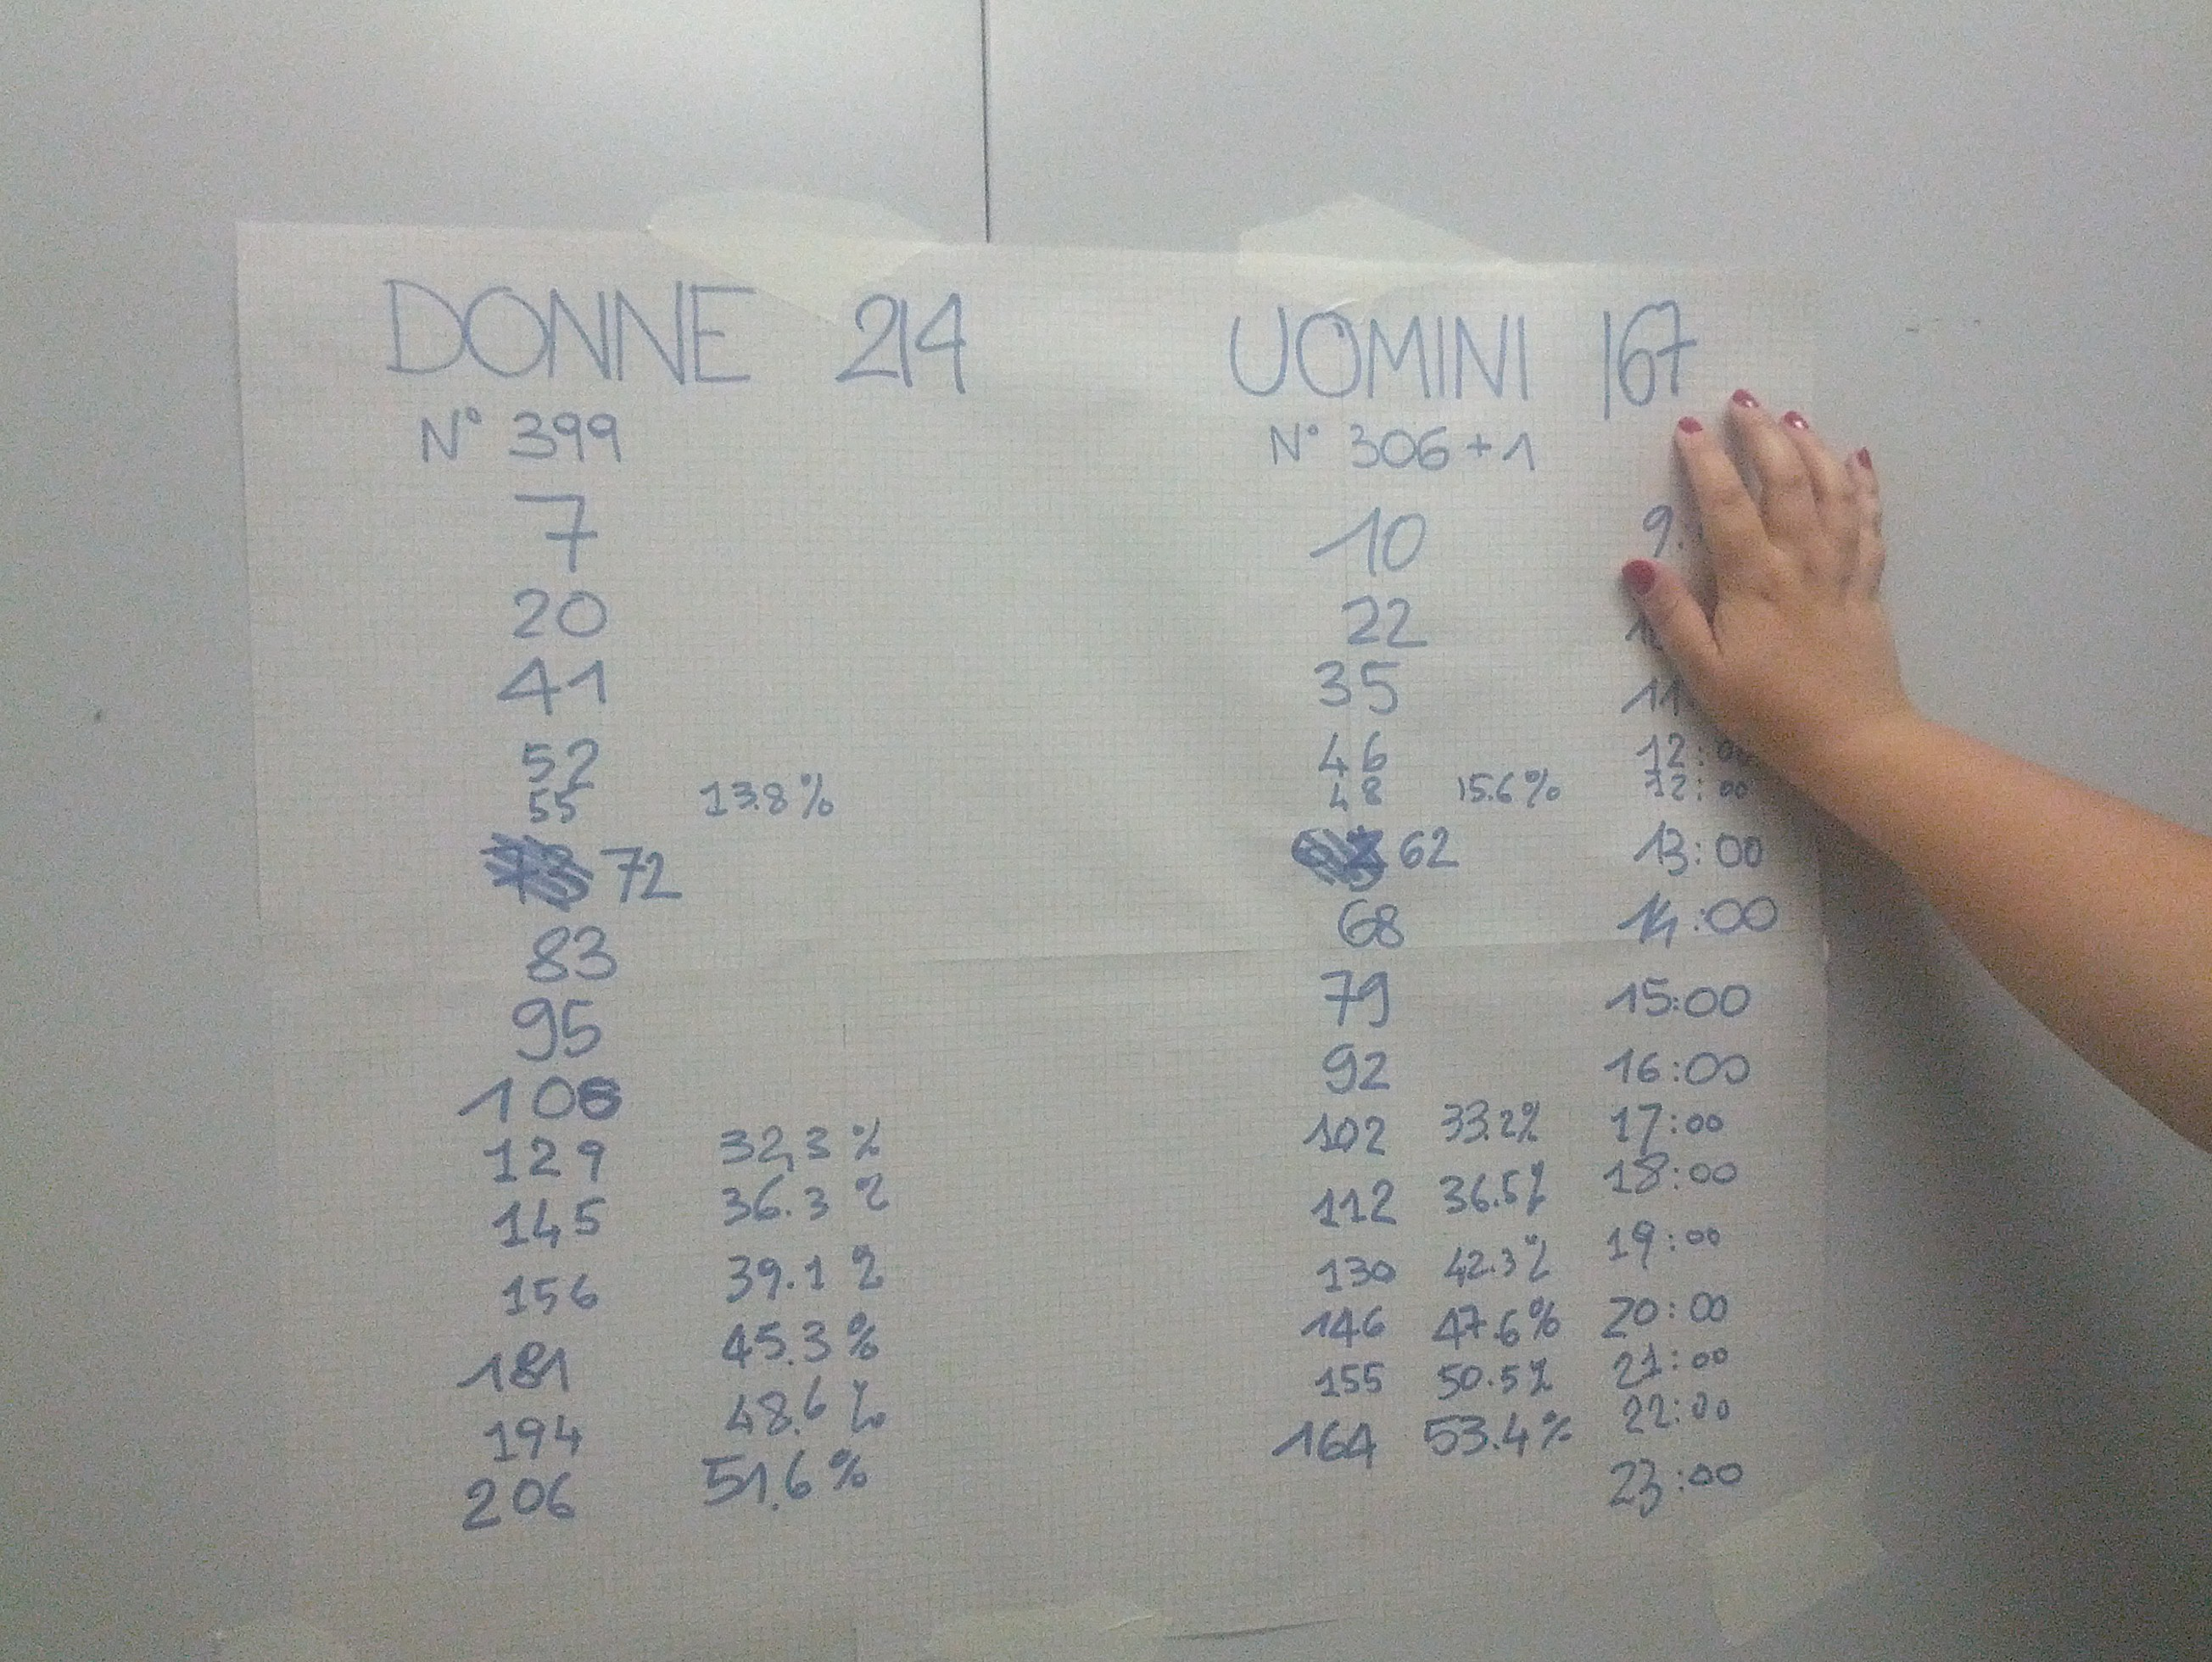

In [1]:
from IPython.display import Image
Image(filename='IMG_20160605_230027.jpg')

In [2]:
DONNE_ISCRITTE = 399

In [3]:
UOMINI_ISCRITTI = 307

In [4]:
ISCRITTI = DONNE_ISCRITTE + UOMINI_ISCRITTI
AFFLUENZA = .68 * ISCRITTI # affluenza "a priori", sul dato della zona per le elezioni 2011

In [5]:
donne =  { 2: 7,  3: 20, 4: 41, 5: 52, 6: 55, 7: 72, 8: 83, 
           9: 95, 10: 108, 11: 129, 12: 145, 13: 156, 14: 181, 15: 194, 16: 206 }
uomini = { 2: 10, 3: 22, 4: 35, 5: 46, 6: 48, 7: 62, 8: 68, 
           9: 79, 10: 92,  11: 102, 12: 112, 13: 130, 14: 146, 15: 155, 16: 164 } 

In [6]:
votanti = max(donne.values()) + max(uomini.values())

print "Votanti {}, Affluenza {}%".format(votanti, round(votanti/float(ISCRITTI), 3)*100)

Votanti 370, Affluenza 52.4%


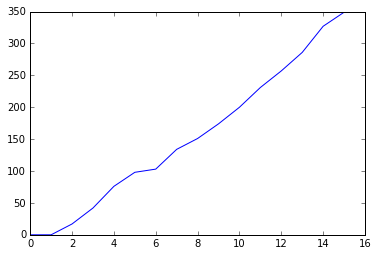

In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
elettori = [(0 if (i not in donne) else donne[i]) + (0 if (i not in uomini) else uomini[i]) for i in xrange(max(donne.keys() + uomini.keys()))]
plt.plot(range(len(elettori)), elettori)

# Dati del 19/6/2016

In [8]:
ndonne =  { 2: 8,  3: 25, 4: 50, 5: 73, 6: 85, 7: 91, 8: 102, 9: 112, 10: 124, 11: 132}
nuomini = { 2: 7,  3: 23, 4: 38, 5: 51, 6: 63, 7: 67, 8: 73,  9: 84,  10: 92,  11: 102} 

In [9]:
nvotanti = max(ndonne.values()) + max(nuomini.values())

nvotanti

234

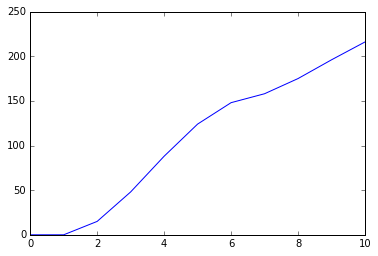

In [10]:
elettori = [(0 if (i not in ndonne) else ndonne[i]) + (0 if (i not in nuomini) else nuomini[i]) for i in xrange(max(ndonne.keys() + nuomini.keys()))]
plt.plot(range(len(elettori)), elettori)

# Il modello statistico

In [11]:
import pystan

In [12]:
model = """
data {
 int<lower=0> ORE;
 int<lower=0> OTOT;
 real<lower=0> AFF;
 int<lower=0> NOW;
 int<lower=0> PRED;
 int<lower=NOW> END;

 int votanti[ORE];
}
parameters {
    real<lower=0> lambda;
    real<lower=0> sigma;
} 
model {
  votanti ~ poisson(lambda);
  lambda ~ normal(AFF, sigma);
  sigma ~ cauchy(0, 10);
}
generated quantities {
    int prediction_now;
    int prediction_end;
    prediction_now <- -OTOT;
    for (i in 1:ORE){
       prediction_now <- prediction_now + votanti[i];
    }
    for (i in 1:PRED) {
      prediction_now <- prediction_now + poisson_rng(lambda);
    }
    prediction_end <- prediction_now;
    for (i in NOW+PRED:END) {
      prediction_end <- prediction_end + poisson_rng(lambda);
    }
}

"""

In [13]:
oore = max(donne.keys() + uomini.keys())
affluenza_ora = AFFLUENZA / oore
nore = max(ndonne.keys() + nuomini.keys())
ore = oore + nore
elettori_ora = []
for i in xrange(oore+1):
    elettori_ora.append((0 if (i not in donne) else donne[i]) - (0 if (i-1 not in donne) else donne[i-1]))
    elettori_ora[i] += (0 if (i not in uomini) else uomini[i]) - (0 if (i-1 not in uomini) else uomini[i-1])
    
for i in xrange(nore+1):
    elettori_ora.append((0 if (i not in ndonne) else ndonne[i]) - (0 if (i-1 not in ndonne) else ndonne[i-1]))
    elettori_ora[oore+1+i] += (0 if (i not in nuomini) else nuomini[i]) - (0 if (i-1 not in nuomini) else nuomini[i-1])
    
    
assert(sum(elettori_ora) == donne[oore] + uomini[oore] + ndonne[nore] + nuomini[nore]) 
print elettori_ora, len(elettori_ora)

[0, 0, 17, 25, 34, 22, 5, 31, 17, 23, 26, 31, 26, 29, 41, 22, 21, 0, 0, 15, 33, 40, 36, 24, 10, 17, 21, 20, 18] 29


In [14]:
data_dict = {'ORE': len(elettori_ora), 
             'votanti':  elettori_ora,
             'OTOT': votanti,
             'PRED': 1,
             'NOW': nore,
             'AFF': affluenza_ora,
             'END': oore}

fit = pystan.stan(model_code=model, data=data_dict, iter=2000, chains=4)
ris = fit.extract()

In [15]:
now = nuomini[nore] + ndonne[nore]

In [16]:
print "Votanti ore {}: {} {}%".format(nore + 7, nvotanti, round(nvotanti/float(ISCRITTI),3)*100)
print "Stima ore {}: {} -- {}".format(nore + fit.data['PRED'] + 7, 
                                      round(np.percentile(ris['prediction_now'], .05)), 
                                      round(np.percentile(ris['prediction_now'], .95)))
print "Stima finale: {} -- {}".format(round(np.percentile(ris['prediction_end'], .05)), 
                                      round(np.percentile(ris['prediction_end'], .95)))                                      
print "Affluenza stimata: {}%".format(round(np.percentile(ris['prediction_end'], .5)/ISCRITTI, 3)*100)

Votanti ore 18: 234 33.1%
Stima ore 19: 242.0 -- 245.0
Stima finale: 321.0 -- 332.0
Affluenza stimata: 46.7%
